In [1]:
import silence_tensorflow.auto
from typing import Dict, List
import numpy as np
import pandas as pd
from ensmallen_graph import EnsmallenGraph
from extra_keras_metrics import get_minimal_multiclass_metrics
from tensorflow.keras.layers import Layer
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
import tensorflow as tf
from embiggen.visualizations import GraphVisualizations
from plot_keras_history import plot_history
from tqdm.auto import tqdm
from sklearn.decomposition import PCA

In [2]:
from ensmallen_graph.datasets.linqs import Cora, CiteSeer, PubMedDiabetes

complete_graph = Cora()
graph = complete_graph.remove(deny_node_types_set=set(["Word"]))

graph.enable(
    vector_destinations=True,
    vector_outbounds=True
)

In [3]:
def get_words_data(graph: EnsmallenGraph):
    word_node_type = graph.get_node_type_names().index("Word")
    weights = graph.get_weights() if graph.has_weights() else None
    return pd.DataFrame({
        node_name: {
            graph.get_node_name(source): weights[graph.get_edge_id(source, node_id)] if weights else 1
            for source in graph.get_filtered_neighbours(node_id)
        }
        for node_id, node_name in enumerate(tqdm(graph.get_node_names(), desc="Extracting words features"))
        if graph.get_node_type(node_id) == word_node_type
    }).fillna(0)
words_features = get_words_data(complete_graph)
words_features

Extracting words features:   0%|          | 0/4141 [00:00<?, ?it/s]

,word_0,word_1,word_2,word_3,word_4,word_5,word_6,word_7,word_8,word_9,...,word_1423,word_1424,word_1425,word_1426,word_1427,word_1428,word_1429,word_1430,word_1431,word_1432
1153728,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
950052,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1152858,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1114502,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
362926,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1130676,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
42209,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11335,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
628667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [27]:
labels = pd.DataFrame(
    graph.get_node_types().reshape(-1, 1),
    index=graph.get_node_names(),
    columns=["label"]
)
labels = pd.get_dummies(labels, columns=labels.columns)
labels

,label_0,label_1,label_2,label_3,label_4,label_5,label_6
31336,1,0,0,0,0,0,0
1061127,0,1,0,0,0,0,0
1106406,0,0,1,0,0,0,0
13195,0,0,1,0,0,0,0
37879,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...
1128975,0,0,0,0,0,1,0
1128977,0,0,0,0,0,1,0
1128978,0,0,0,0,0,1,0
117328,0,0,0,0,0,0,1


In [45]:
labels.isna().any()

label_0    False
label_1    False
label_2    False
label_3    False
label_4    False
label_5    False
label_6    False
dtype: bool

In [31]:
concatenate = pd.concat([
    words_features,
    labels
], axis=1)

In [32]:
correlations = concatenate.corr()

In [46]:
correlations

word_0     True
word_1     True
word_2     True
word_3     True
word_4     True
           ... 
label_2    True
label_3    True
label_4    True
label_5    True
label_6    True
Length: 1440, dtype: bool

(<Figure size 2000x2000 with 2 Axes>,
 <AxesSubplot:title={'center':'Nodes degrees - Cora'}>)

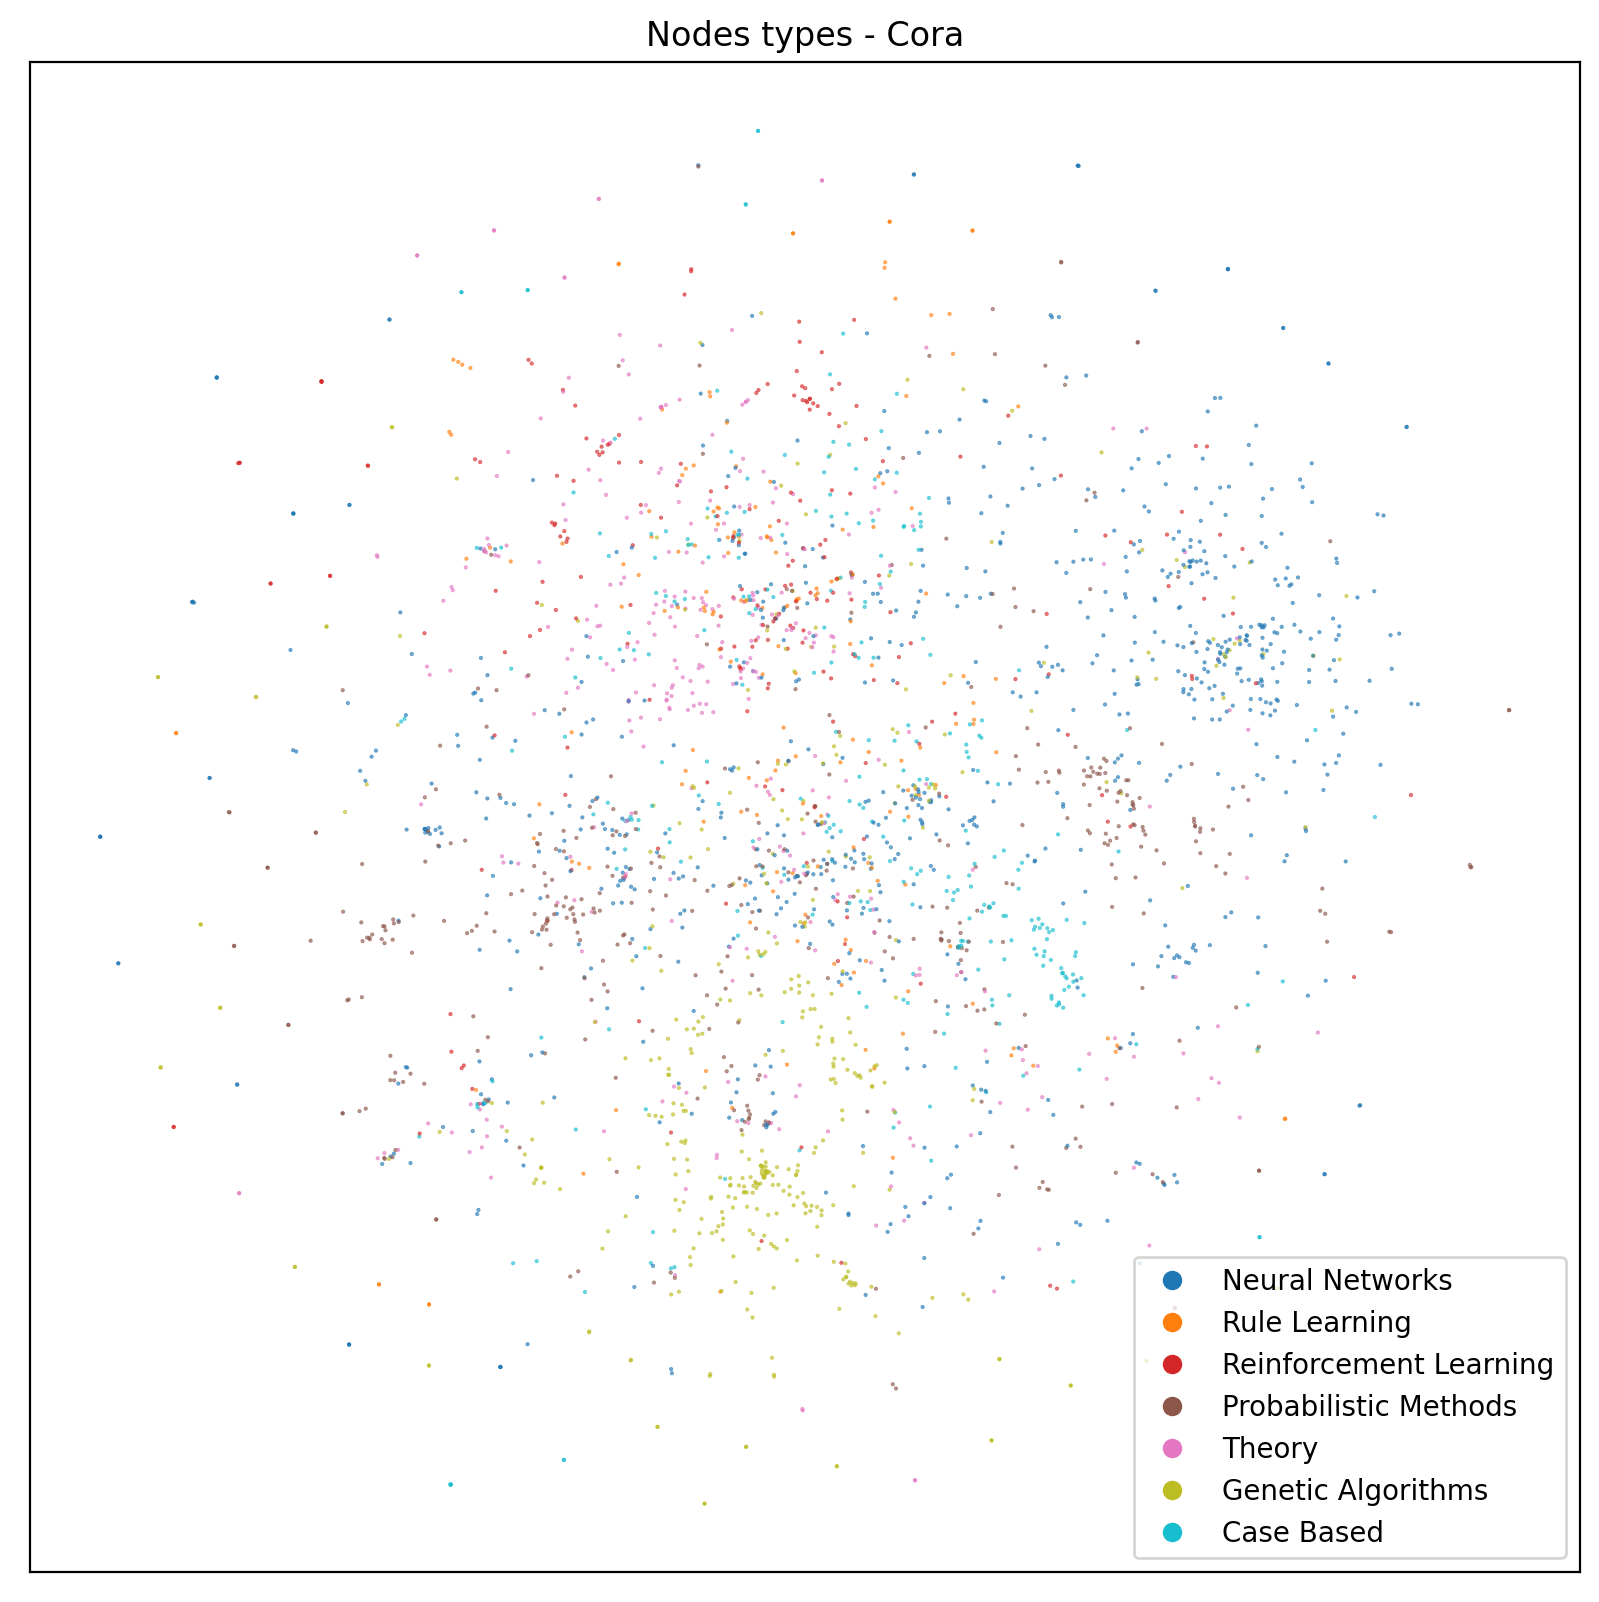

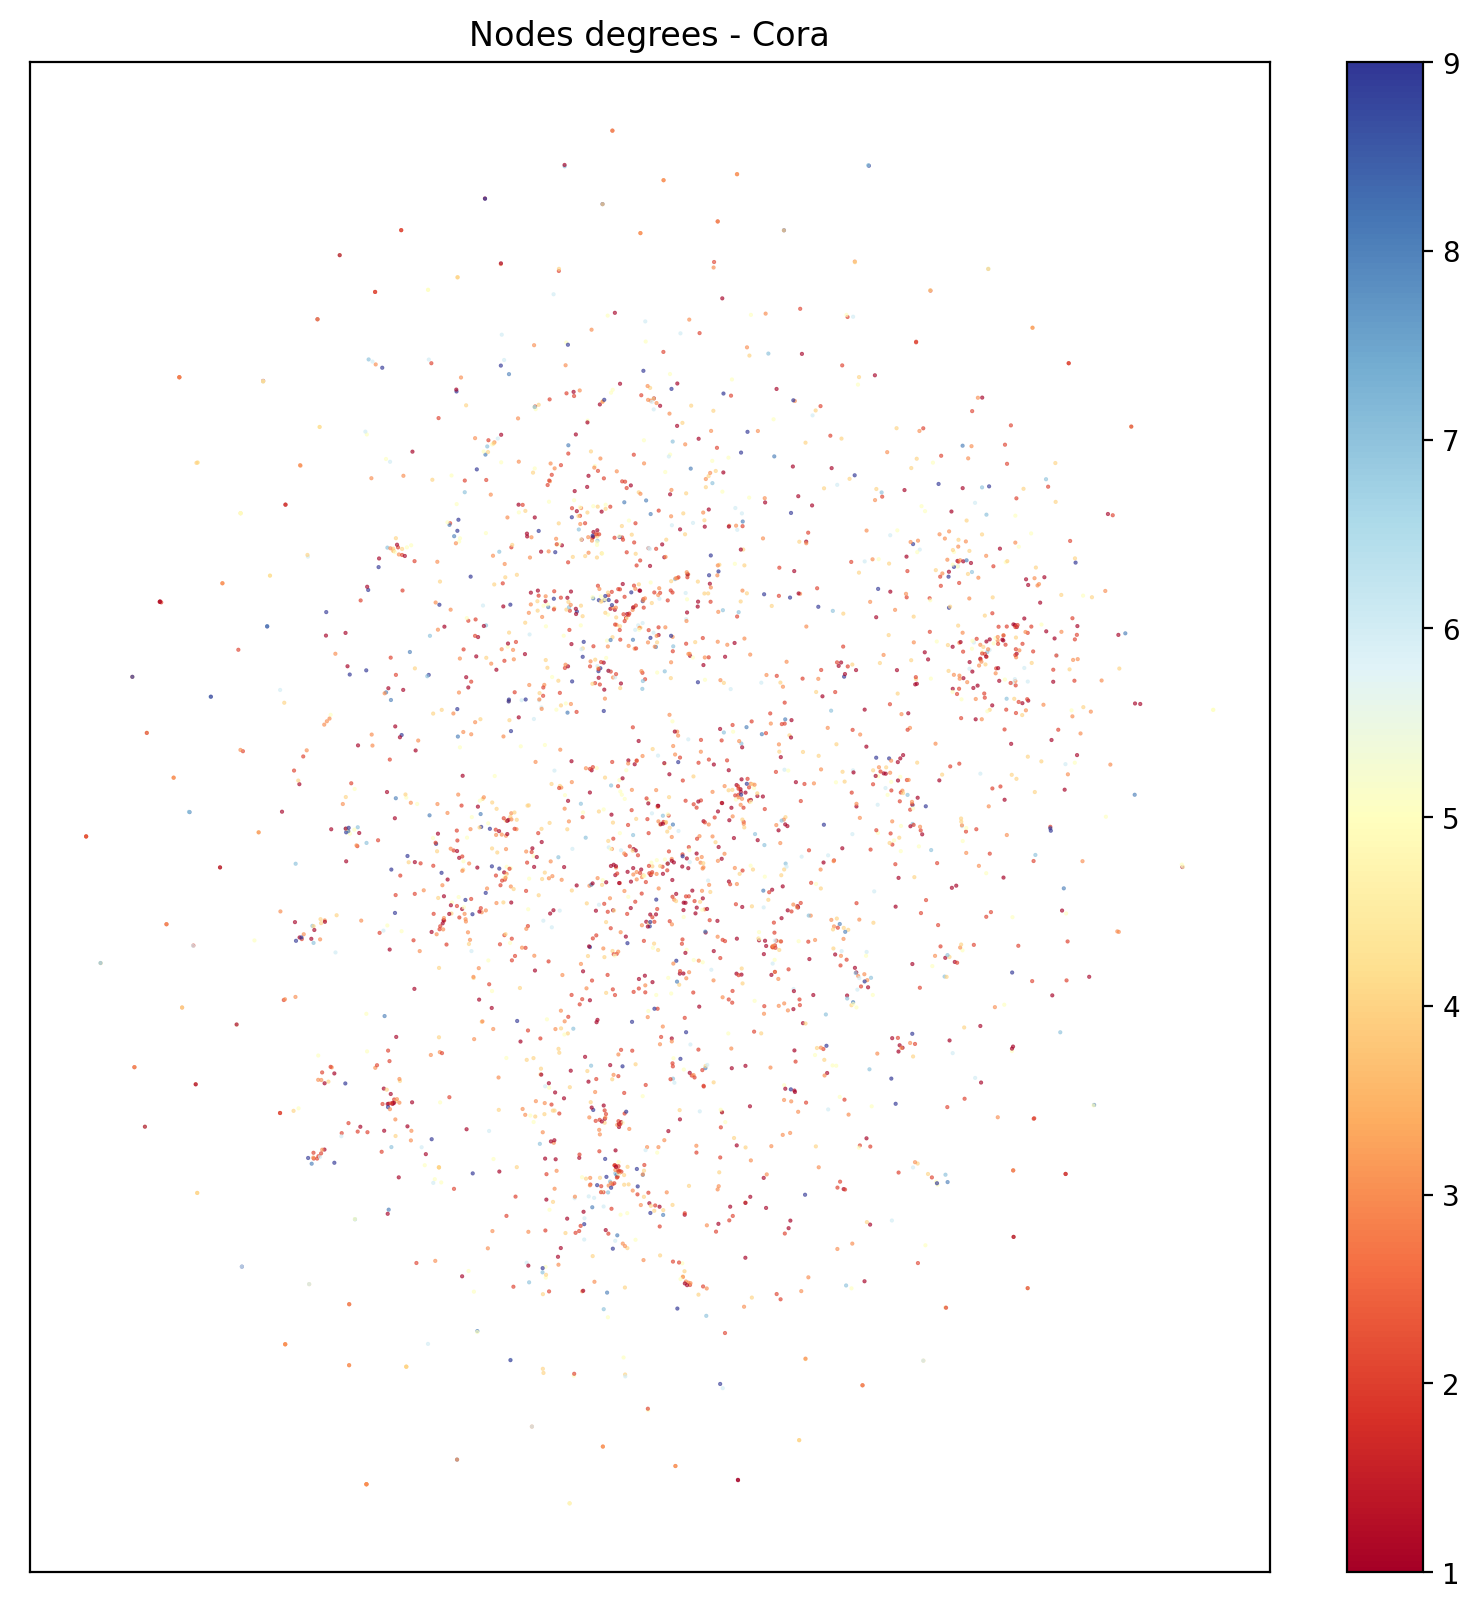

In [6]:
visualization = GraphVisualizations()
visualization.fit_transform_nodes(graph, words_features, verbose=True)
visualization.plot_node_types(graph)
visualization.plot_node_degrees(graph)